In [1]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import folium
from shapely.geometry import LineString
from folium import Map, PolyLine
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle


In [2]:
import geopandas as gpd

# Load saved edges GeoDataFrame
edges = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/edges_roads_with_curvature.gpkg", layer='edges')
nodes = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/nodes_roads_with_curvature.gpkg", layer='nodes')

edges.set_index(['u', 'v', 'key'], inplace=True)
nodes.set_index(['osmid'], inplace=True)
# Reconstruct the graph
G = ox.graph_from_gdfs(nodes, edges)
start_lat = 53.1701   # Parsley Hay Car Park lat
start_lon = -1.7816  # Parsley Hay Car Park lon

start_node = ox.nearest_nodes(G, start_lon, start_lat)

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
C:\Users\khong\AppData\Local\Temp\ipykernel_8684\1545879209.py:4: SyntaxWarning: invalid escape sequence '\k'
  edges = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/edges_roads_with_curvature.gpkg", layer='edges')
C:\Users\khong\AppData\Local\Temp\ipykernel_8684\1545879209.py:5: SyntaxWarning: invalid escape sequence '\k'
  nodes = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/nodes_roads_with_curvature.gpkg", layer='nodes')


In [3]:
def curvature_weighted_dfs(G, start_node, target_distance=2000, max_depth=20, top_k=2, max_paths=1000):
    stack = [([start_node], 0)]
    outbound_paths = []

    while stack and len(outbound_paths) < max_paths:
        new_stack = stack
        stack = []
        for option in new_stack:
            path, total_length = option
            current_node = path[-1]

            if total_length >= target_distance or len(path) > max_depth:
                outbound_paths.append(path)
                continue

            candidates = []

            for neighbor in G.successors(current_node):
                if neighbor in path:
                    continue  # avoid node re-use

                for key, data in G[current_node][neighbor].items():
                    length = data.get("length", 0)
                    curvature = data.get("curvature", 0)
                    score = (curvature+0.01) * length
                    candidates.append((score, neighbor, length))

            # Sort and take top-k
            candidates.sort(reverse=True)
            top_choices = candidates[:top_k]

            for _, next_node, edge_length in top_choices:
                new_path = path + [next_node]
                new_total_length = total_length + edge_length
                stack.append((new_path, new_total_length))

    return outbound_paths

outbound_paths = curvature_weighted_dfs(G, start_node, target_distance=15000, max_depth=50, top_k=2, max_paths=20000)
print("Number of paths found:", {len(outbound_paths)})

Number of paths found: {25168}


In [43]:
def analyze_path_metrics(G, path, path_id):
    total_length = 0
    curvatures = []
    speedlims = []
    road_names = set()

    for u, v in zip(path[:-1], path[1:]):
        if G.has_edge(u, v):
            # For MultiDiGraph, get all edges between u and v
            edge_data = G.get_edge_data(u, v)
            if edge_data:
                # Choose edge with maximum curvature * length
                best_key = max(
                    edge_data,
                    key=lambda k: edge_data[k].get('curvature', 0) * edge_data[k].get('length', 0)
                )
                data = edge_data[best_key]

                total_length += data.get("length", 0)
                curvatures.append(data.get("curvature", 0) / data.get("length", 1))

                # Get speed limit
                speed_limit = data.get("maxspeed")
                if isinstance(speed_limit, str):
                    try:
                        speedlims.append(int(speed_limit.removesuffix(' mph')) / data.get("length", 1))
                    except:
                        speedlims.append(30 / data.get("length", 1))
                elif speed_limit is None:
                    speedlims.append(30)

                # Add road name(s) to set (can be list or string)
                name = data.get("name")
                if isinstance(name, list):
                    road_names.update(name)
                elif isinstance(name, str):
                    road_names.add(name)
                elif name is None:
                    road_names.add(data.get("osmid"))
        else:
            print(f"Warning: no edge from {u} to {v}")

    avg_curvature = sum(curvatures) / len(curvatures) if curvatures else 0
    num_unique_roads = len(road_names) / len(path)
    avg_speed = sum(speedlims) / len(speedlims)

    # calculate bearing relative to start point
    node_centroid = (np.average(nodes[nodes.index.isin(path)]['y']), np.average(nodes[nodes.index.isin(path)]['x']))
    bearing = np.atan2((node_centroid[0]-start_lat), (node_centroid[1]-start_lon))

    return pd.DataFrame({
        "path_id": path_id,
        "total_length": total_length,
        "avg_curvature": avg_curvature,
        "unique_road_num": num_unique_roads,
        "avg_speed": avg_speed,
        "bearing": bearing,
        "path_nodes": [path]
    })


In [44]:
def polar_plot(bearing_vector, score_vector, colour_key):
    label_to_color = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange'
    }
    colors = [label_to_color[label] for label in colour_key]

    # Create polar plot using scatter
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(bearing_vector, score_vector, c=colors)

    plt.show()


In [ ]:

def normalize_vector(vec):
    vec = np.array(vec)
    return (vec - vec.min()) / (vec.max() - vec.min()) if vec.max() > vec.min() else np.zeros_like(vec)

def calculate_scores(G, input_paths):
    path_metrics = pd.DataFrame(columns=['path_id', 'total_length', 'avg_curvature', 'unique_road_num', 'avg_speed', 'bearing', 'path_nodes'])
    for idx, path in enumerate(input_paths):
        path_metrics = pd.concat([path_metrics, analyze_path_metrics(G, path, idx)])
    
    curvature_vector_norm = normalize_vector(path_metrics['avg_curvature'].to_list())
    roadnumber_vector_norm = normalize_vector(path_metrics['unique_road_num'].to_list())
    speed_vector_norm = normalize_vector(path_metrics['avg_speed'].to_list())
    score_vector = 2*curvature_vector_norm - roadnumber_vector_norm + speed_vector_norm

    path_metrics['score'] = score_vector

    return path_metrics

results = calculate_scores(G, outbound_paths)


C:\Users\khong\AppData\Local\Temp\ipykernel_8684\963166154.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  path_metrics = pd.concat([path_metrics, analyze_path_metrics(G, path, idx)])


In [57]:
path_metrics = results


In [7]:
import pandas as pd
from tqdm import tqdm

# Example structure
# df = pd.DataFrame({
#     'id': range(10000),
#     'ints': [...],  # list of ints
#     'score': [...]
# })

# Convert lists to sets for faster operations
results['path_nodes_set'] = results['path_nodes'].apply(set)

# Sort by score descending
results = results.sort_values('score', ascending=False).reset_index(drop=True)

# Similarity threshold
threshold = 0.5

# Store accepted list indices
accepted_indices = []
accepted_sets = []

for i, row in tqdm(results.iterrows(), total=len(results)):
    current_set = row['path_nodes_set']
    is_similar = False
    for other_set in accepted_sets:
        intersection = len(current_set & other_set)
        union = len(current_set | other_set)
        similarity = intersection / union
        if similarity >= threshold:
            is_similar = True
            break
    if not is_similar:
        accepted_indices.append(i)
        accepted_sets.append(current_set)

# Result
filtered_results = results.loc[accepted_indices].reset_index(drop=True)


100%|██████████| 25168/25168 [00:06<00:00, 4108.77it/s]


In [8]:
filtered_results

,path_id,total_length,avg_curvature,road_uniqueness,speed,bearing,score,path_nodes,path_nodes_set
0,19698,15001.175789,216.461123,0.583333,9.840906,0.641006,1.812531,"[324736120, 27284783, 2386803095, 29389528, 21...","{5933532288, 42204930, 4489665795, 4489665799,..."
1,21167,15007.764205,101.420618,0.458333,15.116393,1.825291,1.101256,"[324736120, 27284783, 2386803095, 27284404, 20...","{2386803095, 207275929, 97743514, 207274905, 4..."
2,15864,15084.048344,116.705524,0.565217,12.109511,2.067485,0.995683,"[324736120, 27284783, 2386803095, 27284404, 20...","{1036436225, 2386803095, 207275929, 207274905,..."
3,20424,15050.145063,116.699127,0.708333,15.569778,1.856660,0.939020,"[324736120, 27284783, 2386803095, 27284404, 20...","{938649866, 2386803095, 207275929, 409794205, ..."
4,19016,15285.063738,38.570604,0.375000,22.316065,3.027330,0.890039,"[324736120, 27284783, 27284738, 243346569, 273...","{27284738, 367095816, 243346569, 319729931, 31..."
...,...,...,...,...,...,...,...,...,...
234,17468,15829.092990,35.155657,0.739130,0.633515,0.786428,-0.401981,"[324736120, 243347237, 2186949600, 29389528, 2...","{2518979329, 262301830, 243347210, 410860304, ..."
235,6547,15282.143571,0.574002,0.850000,12.748709,-0.966763,-0.420357,"[324736120, 243347237, 243347348, 243347352, 2...","{243347348, 827154326, 367118999, 827154327, 3..."
236,2932,15027.249707,6.030143,0.684211,5.372988,0.145289,-0.427602,"[324736120, 27284783, 2386803095, 29389528, 21...","{243347464, 243347348, 430006677, 2386803095, ..."
237,1511,15106.835051,16.535837,0.705882,2.351474,1.666532,-0.468789,"[324736120, 243347237, 2186949600, 29389528, 2...","{2186949600, 332790435, 3221839972, 243347237,..."


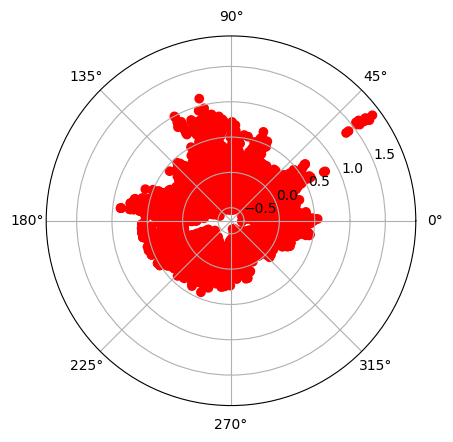

In [9]:
polar_plot(results['bearing'].to_list(), results['score'].to_list(), np.zeros(len(results['bearing'].to_list())))


In [10]:
# OLD: Use signal processing to identify peaks
# from scipy.signal import find_peaks
# analysis_vec = results.sort_values(by='bearing')['score'].values

# peaks_idx, _ = find_peaks(analysis_vec, distance=200)  # tune `distance` for diversity

# best_paths = results.sort_values(by='bearing').iloc[peaks_idx]

# # print(best_paths)
# # print(results.sort_values(by='bearing').iloc[peaks_idx]['path_id'].values)

In [11]:
import numpy as np
from sklearn.cluster import KMeans

def cluster_routes_by_bearing_and_score(bearings, scores, n_clusters=3):
    """
    Cluster route bearings using polar coordinates and scores.
    
    bearings: list of bearing values in degrees
    scores: list of route scores

    Returns:
        cluster_labels: array of cluster assignments for each route
    """
    # Convert bearings to radians and use unit circle projection
    radians = bearings
    x = np.cos(radians)
    y = np.sin(radians)
    
    # Combine with score to cluster in 3D space
    X = np.column_stack([x, y, scores])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    
    return labels

labels = cluster_routes_by_bearing_and_score(filtered_results['bearing'].to_list(), filtered_results['score'].to_list(), n_clusters=4)
filtered_results['labels'] = labels

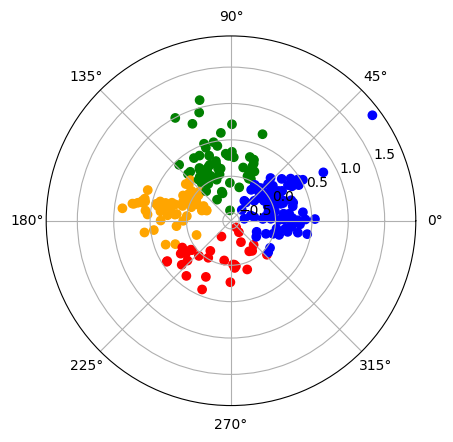

In [12]:
polar_plot(filtered_results['bearing'].to_list(), filtered_results['score'].to_list(), labels)

In [13]:
filtered_results

,path_id,total_length,avg_curvature,road_uniqueness,speed,bearing,score,path_nodes,path_nodes_set,labels
0,19698,15001.175789,216.461123,0.583333,9.840906,0.641006,1.812531,"[324736120, 27284783, 2386803095, 29389528, 21...","{5933532288, 42204930, 4489665795, 4489665799,...",1
1,21167,15007.764205,101.420618,0.458333,15.116393,1.825291,1.101256,"[324736120, 27284783, 2386803095, 27284404, 20...","{2386803095, 207275929, 97743514, 207274905, 4...",2
2,15864,15084.048344,116.705524,0.565217,12.109511,2.067485,0.995683,"[324736120, 27284783, 2386803095, 27284404, 20...","{1036436225, 2386803095, 207275929, 207274905,...",2
3,20424,15050.145063,116.699127,0.708333,15.569778,1.856660,0.939020,"[324736120, 27284783, 2386803095, 27284404, 20...","{938649866, 2386803095, 207275929, 409794205, ...",2
4,19016,15285.063738,38.570604,0.375000,22.316065,3.027330,0.890039,"[324736120, 27284783, 27284738, 243346569, 273...","{27284738, 367095816, 243346569, 319729931, 31...",3
...,...,...,...,...,...,...,...,...,...,...
234,17468,15829.092990,35.155657,0.739130,0.633515,0.786428,-0.401981,"[324736120, 243347237, 2186949600, 29389528, 2...","{2518979329, 262301830, 243347210, 410860304, ...",1
235,6547,15282.143571,0.574002,0.850000,12.748709,-0.966763,-0.420357,"[324736120, 243347237, 243347348, 243347352, 2...","{243347348, 827154326, 367118999, 827154327, 3...",0
236,2932,15027.249707,6.030143,0.684211,5.372988,0.145289,-0.427602,"[324736120, 27284783, 2386803095, 29389528, 21...","{243347464, 243347348, 430006677, 2386803095, ...",1
237,1511,15106.835051,16.535837,0.705882,2.351474,1.666532,-0.468789,"[324736120, 243347237, 2186949600, 29389528, 2...","{2186949600, 332790435, 3221839972, 243347237,...",2


In [14]:

def select_top_paths_by_cluster(filtered_results: pd.DataFrame, top_n=1) -> pd.DataFrame:
    """
    Selects top N scoring paths from each cluster in a DataFrame.

    Returns:
        A DataFrame containing the top N paths from each cluster, retaining all columns.
    """
    top_paths_df = (
        filtered_results
        .sort_values(['labels', 'score'], ascending=[True, False])  # sort by cluster, then score descending
        .groupby('labels', group_keys=False)
        .head(top_n)
    )
    return top_paths_df.reset_index(drop=True)


best_paths = select_top_paths_by_cluster(filtered_results, top_n=5)



In [15]:
loops = [outbound_paths[i] for i in best_paths['path_id'].to_list()]

# --- Create Folium map ---
m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# Plot start
folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

def get_color(val, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    rgba = cmap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

# Color cycle for the paths
colors = cycle(['red', 'blue', 'green', 'purple', 'orange'])

for path in loops:

    path_edges = []

    for u, v in zip(path[:-1], path[1:]):
        # Get all parallel edges between u and v (MultiDiGraph may have >1)
        edge = G.get_edge_data(u, v)
        
        if edge:
            # Select the shortest edge (or first) if multiple exist
            edge_data = min(edge.values(), key=lambda d: d.get('length', float('inf')))
            path_edges.append(edge_data)
            curvature = edge_data.get('curvature', 0)

    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

    # Add edges to the map
    for row in path_edges:
        if isinstance(row['geometry'], list):
            # Skip any weird geometry
            continue
        # COLOUR CODE by curvature
        # folium.PolyLine(locations=[(lat, lon) for lon, lat in row['geometry'].coords],
        #                 color=get_color(row['curvature'], edges['curvature'].min(), edges['curvature'].max()),
        #                 weight=5).add_to(m)

    # COLOUR CODE by distinct paths
    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(coords, color=next(colors), weight=5, opacity=0.3).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin([loops[0][0]][0])].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# Show map
m

In [16]:
best_outbound = [outbound_paths[i] for i in best_paths['path_id'].to_list()]

def get_edges_from_path(G, node_path):
    """
    Given a list of node IDs representing a path, return a list of (u, v, key) edges.
    Assumes G is a MultiDiGraph where multiple edges may exist between nodes.
    """
    edges = []
    for i in range(len(node_path) - 1):
        u = node_path[i]
        v = node_path[i + 1]

        if G.has_edge(u, v):
            # Choose the first matching edge key if multiple exist
            key = list(G[u][v].keys())[0]
            edges.append((u, v, key))
        else:
            print(f"Warning: No edge from {u} to {v} in graph.")
    return edges


def build_return_graph(G, outbound_edges, curvature_weight=1.0, reuse_penalty=10000):
    G_ret = G.copy()
    for u, v, k, data in G_ret.edges(keys=True, data=True):
        base_cost = 1  # or use length, if you want to bias short paths
        curvature = data.get("curvature", 0)
        reuse = (u, v, k) in outbound_edges or (v, u, k) in outbound_edges

        cost = base_cost - curvature_weight * curvature
        if reuse:
            cost += reuse_penalty

        G_ret[u][v][k]["weight"] = max(cost, 0.01)  # prevent zero or negative weights

    return G_ret

full_loops = []
for out_path in best_outbound:
    outbound_edges = get_edges_from_path(G, out_path)
    G_return = build_return_graph(G, outbound_edges)
    return_path = nx.shortest_path(G_return, source=out_path[-1], target=start_node, weight="weight")
    full_loops.append(out_path + return_path[1:])  # skip duplicate end/start node
    
# # Plot full path nodes
# # --- Create Folium map ---
# m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# # Plot start
# folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin(full_loop)].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# # Show map
# m

In [17]:
loops = full_loops

# --- Create Folium map ---
m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# Plot start
folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

def get_color(val, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    rgba = cmap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

# Color cycle for the paths
colors = cycle(['red', 'blue', 'green', 'purple', 'orange'])

for path in loops:

    path_edges = []

    for u, v in zip(path[:-1], path[1:]):
        # Get all parallel edges between u and v (MultiDiGraph may have >1)
        edge = G.get_edge_data(u, v)
        
        if edge:
            # Select the shortest edge (or first) if multiple exist
            edge_data = min(edge.values(), key=lambda d: d.get('length', float('inf')))
            path_edges.append(edge_data)
            curvature = edge_data.get('curvature', 0)

    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

    # Add edges to the map
    for row in path_edges:
        if isinstance(row['geometry'], list):
            # Skip any weird geometry
            continue
        # COLOUR CODE by curvature
        # folium.PolyLine(locations=[(lat, lon) for lon, lat in row['geometry'].coords],
        #                 color=get_color(row['curvature'], edges['curvature'].min(), edges['curvature'].max()),
        #                 weight=5).add_to(m)

    # COLOUR CODE by distinct paths
    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(coords, color=next(colors), weight=5, opacity=0.3).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin([loops[0][0]][0])].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# Show map
m

In [20]:
secondary_results = calculate_score(G, full_loops)

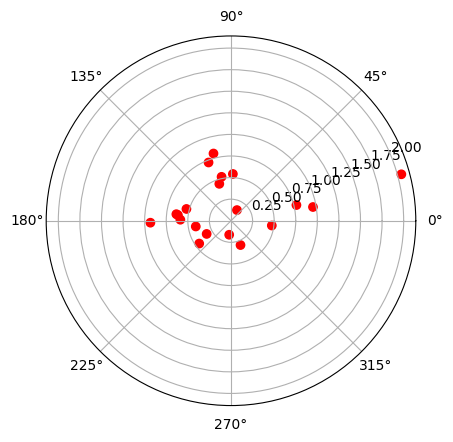

In [22]:
polar_plot(secondary_results['bearing'].to_list(), secondary_results['score'].to_list(), np.zeros(len(secondary_results['bearing'].to_list())))

In [78]:
proposed_routes = secondary_results.sort_values(by='score', ascending=False).head(5)

In [79]:

from folium.features import DivIcon

# --- Create Folium map ---
m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# Plot start
folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='gray')).add_to(m)

def get_color(val, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('jet')
    rgba = cmap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

path_ids = proposed_routes['path_id'].values.tolist()
colors = cycle(['red', 'blue', 'green', 'purple', 'orange'])
for path_num, path in enumerate(proposed_routes['path_nodes'].values.tolist()):

    path_edges = []
    path_color = next(colors)

    for u, v in zip(path[:-1], path[1:]):
        # Get all parallel edges between u and v (MultiDiGraph may have >1)
        edge = G.get_edge_data(u, v)
        
        if edge:
            # Select the shortest edge (or first) if multiple exist
            edge_data = min(edge.values(), key=lambda d: d.get('length', float('inf')))
            path_edges.append(edge_data)
            curvature = edge_data.get('curvature', 0)

    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

    # Add edges to the map
    for row in path_edges:
        if isinstance(row['geometry'], list):
            # Skip any weird geometry
            continue
        folium.PolyLine(locations=[(lat, lon) for lon, lat in row['geometry'].coords],
                        color=path_color,
                        weight=5).add_to(m)

    marker_node = path[len(path)//2]
    folium.map.Marker([G.nodes[marker_node]['y'], G.nodes[marker_node]['x']],
                      popup="Path ID: "+str(path_ids[path_num]),
                      icon=DivIcon(icon_size=(150,36),
                                   icon_anchor=(7,20),
                                   html='<div style="font-size: 11pt; color : black">'+ 'Path ID: ' + str(path_ids[path_num]) +'</div>')
                      ).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin([loops[0][0]][0])].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# Show map
m